In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import sys
import os
import copy
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import scipy

import torch
import torchvision
import torchvision.transforms as transforms

# for creating validation set
from sklearn.model_selection import train_test_split

%matplotlib notebook
%matplotlib notebook
# %matplotlib inline
# %matplotlib qt

In [3]:
from google.colab import drive
drive.mount('/content/drive')
!git clone "https://github.com/RichieHakim/basic_neural_processing_modules.git" "/content/drive/MyDrive/00 - ROI/basic_neural_processing_modules"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fatal: destination path '/content/drive/MyDrive/00 - ROI/basic_neural_processing_modules' already exists and is not an empty directory.


In [4]:
!pip install pycuda

In [5]:
import sys

# sys.path.append(r'/media/rich/Home_Linux_partition/github_repos')
# sys.path.append('/Users/Josh/Documents/github_repos/')
sys.path.append(r'/content/drive/MyDrive/00 - ROI')
dir_folders = r'/content/drive/MyDrive/00 - ROI/label_data'


%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import torch_helpers, decomposition
from GCaMP_ROI_classifier.old_stuff import util, models, training_simCLR, augmentation, training_classHead

## Import training data

In [6]:
import pickle

with open('/content/drive/MyDrive/00 - ROI/label_data/all_stat_files_20211022.pkl', 'rb') as file:
# with open('/Users/Josh/Documents/Harvard/label_data/all_stat_files_20211022.pkl', 'rb') as file:
# with open('/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/label_data/all_stat_files_20211022.pkl', 'rb') as file:
    statFiles_scraped = pickle.load(file)

In [7]:
# keys_toDelete = [
#     '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\16x_analysis20200514\\Suite2p and MC for denoised movie\\suite2p\\plane0\\stat.npy',
#     '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\round 4 experiments\\mouse 6.28\\20201102\\suite2p_accidentally_run_on_everything\\plane0\\stat.npy',
#     '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\20x\\mouse 2.5\\20200306\\suite2p attemp 2 _tau 1_5\\plane0\\stat.npy',
#     '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\20x\\mouse 2.5\\20200306\\suite2p attempt 1 _tau 2\\plane0\\stat.npy',
#     '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\20x\\mouse 2.5\\20200306\\suite2p attempt 3 _tau 1\\plane0\\stat.npy',
#     '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\AAV\\oldBMIrampExp_20191112_mouse1013A\\ROI extraction\\suite2p\\plane0\\stat.npy',
# ]
# for key in keys_toDelete:
#     del statFiles_scraped[key]

In [8]:
# # keys_toDelete = list(statFiles_scraped.keys())[:len(statFiles_scraped.keys())]
# keys_toDelete = list(statFiles_scraped.keys())[2:]
# for key in keys_toDelete:
#     del statFiles_scraped[key]

In [9]:
# sf_list = util.convert_multiple_stat_files(statFiles_dict=statFiles_scraped, out_height_width=[36,36], max_footprint_width=901, plot_pref=False)

# # images_all = np.concatenate(sf_list, axis=0)
# images_all = np.concatenate([sf_list[ii][:1000] for ii in range(len(sf_list))], axis=0)

# images_all.shape

In [10]:
# images_all_norm = (images_all / np.sum(images_all, axis=(1,2), keepdims=True)) * 255

In [11]:
# # create validation set
# # X_train, X_val, y_train, y_val = train_test_split(images[:], labels[:], test_size = 0.15)
# X_train, X_val, y_train, y_val = train_test_split(images_all_norm, np.arange(images_all.shape[0]), test_size = 0.15)
# (X_train.shape, y_train.shape), (X_val.shape, y_val.shape)

In [12]:
dir_folders = r'/content/drive/MyDrive/00 - ROI/label_data'
# dir_folders = r'/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/label_data'
# dir_folders = r'/users/Josh/Documents/Harvard/label_data'
folders = [r'mouse 6_28 _ day 20200903/',
             r'mouse6_28 _ day20200815/']
fileNames_statFiles = [r'stat.npy']*len(folders)
paths_statFiles = [pathlib.Path(dir_folders) / folders[ii] / fileNames_statFiles[ii] for ii in range(len(folders))]

statFile_import_kwargs = {'out_height_width': [36,36],
                          'max_footprint_width': 241,
                          'plot_pref':True}

sf_all = util.import_multiple_stat_files(   paths_statFiles=paths_statFiles,
                                        fileNames_statFiles=fileNames_statFiles,
                                        out_height_width=[36,36],
                                        max_footprint_width=241,
                                        plot_pref=True)
images_labeled = np.concatenate(sf_all, axis=0) *255
print(f'concatenated images shape: {images_labeled.shape}')

fileNames_labelFiles = ['labels_posthoc_filledIn_allCells.npy',
             'labels_posthoc_all.npy']
paths_labelFiles = [pathlib.Path(dir_folders) / folders[ii] / fileNames_labelFiles[ii] for ii in range(len(folders))]

labels_all = util.import_multiple_label_files(paths_labelFiles=paths_labelFiles,
                                       plot_pref=True)
labels = np.concatenate(labels_all)

assert np.alltrue([sf_all[ii].shape[0] == labels_all[ii].shape[0] for ii in range(len(sf_all))]) , 'num images in stat files does not correspond to num labels'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

concatenated images shape: (9715, 36, 36)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
# tmpd = pd.DataFrame(labels)
# tmpd[1] = tmpd[0]
# tmpd.groupby(0).count()

In [14]:
#code doesn't work with multiple open number maybe (?)

In [15]:
def squeeze_integers(arr):
    """
    Make integers in an array consecutive numbers
     starting from 0. ie. [7,2,7,4,1] -> [3,2,3,1,0].
    Useful for removing unused class IDs from y_true
     and outputting something appropriate for softmax.
    RH 2021
    Args:
        arr (np.ndarray):
            array of integers.
    
    Returns:
        arr_squeezed (np.ndarray):
            array of integers with consecutive numbers
    """
    uniques = np.unique(arr)
    arr_squeezed = copy.deepcopy(arr)
    for val in np.arange(0, np.max(arr)+1):
        if np.isin(val, uniques):
            continue
        else:
            arr_squeezed[arr_squeezed>val] = arr_squeezed[arr_squeezed>val]-1
    return arr_squeezed

In [16]:
labels = squeeze_integers(labels)
images_labeled = images_labeled[labels != 2]
labels = labels[labels != 2]
labels = squeeze_integers(labels)

## Balance classes of inputs

In [17]:
duplicates = 1

images_dup = np.tile(images_labeled , (duplicates , 1 , 1))
labels_dup = np.tile(labels , (duplicates))

print(images_dup.shape)
print(labels_dup.shape)

numToGetTo = np.sum(labels_dup==0)
print(numToGetTo)

print(np.sum(labels_dup==0))
print(np.sum(labels_dup==1))
print(np.sum(labels_dup==4))
print(np.sum(labels_dup==5))
print(images_dup.shape)
print(labels_dup.shape)

(9714, 36, 36)
(9714,)
532
532
620
0
0
(9714, 36, 36)
(9714,)


In [18]:
# create validation set

###### REMOVE WITH ENOUGH RAM
images = images_dup
labels = labels_dup

# X_train, X_val, y_train, y_val = train_test_split(images[:], labels[:], test_size = 0.15)
X_labeled_train, X_labeled_val, y_labeled_train, y_labeled_val = train_test_split(images_dup, labels_dup, test_size = 0.15)
X_train, X_val, y_train, y_val = X_labeled_train, X_labeled_val, y_labeled_train, y_labeled_val
(X_labeled_train.shape, y_labeled_train.shape), (X_labeled_val.shape, y_labeled_val.shape)

(((8256, 36, 36), (8256,)), ((1458, 36, 36), (1458,)))

In [19]:
plt.figure()
plt.hist(labels_dup, 20);

<IPython.core.display.Javascript object>

In [20]:
def idx_to_oneHot(arr, n_classes=None):
    """
    Convert an array of class indices to matrix of
     one-hot vectors.
    RH 2021

    Args:
        arr (np.ndarray):
            1-D array of class indices.
        n_classes (int):
            Number of classes.
    
    Returns:
        oneHot (np.ndarray):
            2-D array of one-hot vectors.
    """
    if n_classes is None:
        n_classes = np.max(arr)+1
    oneHot = np.zeros((arr.size, n_classes))
    oneHot[np.arange(arr.size), arr] = 1
    return oneHot

In [21]:
def rh_cm(y_hat, y_true):
    """
    Compute the confusion matrix from y_hat and y_true.
    y_hat should be either predictions ().
    RH 2021

    Args:
        y_hat (np.ndarray): 
            numpy array of predictions or probabilities. 
            Either PREDICTIONS: 2-D array of booleans
             ('one hots') or 1-D array of predicted 
             class indices.
            Or PROBABILITIES: 2-D array floats ('one hot
             like')
        y_true (np.ndarray):
            1-D array of true class indices.
    """
    n_classes = np.max(y_true)+1
    if y_hat.ndim == 1:
        y_hat = idx_to_oneHot(y_hat, n_classes)
    cmat = y_hat.T @ idx_to_oneHot(y_true, n_classes)
    return cmat / np.sum(cmat, axis=0)[None,:]
#     return cmat / torch.sum(cmat, dim=0)[None,:]

## Define augmentation pipeline

In [22]:
import torchvision.transforms    

transforms = torch.nn.Sequential(
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    
    torchvision.transforms.GaussianBlur(kernel_size=5,
                                        sigma=(0.0001, 0.5)),
    
    torchvision.transforms.RandomPerspective(distortion_scale=0.4, 
                                             p=0.5, 
                                             interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
                                             fill=0),
    torchvision.transforms.RandomAffine(
                                        degrees=(-180,180),
                                        translate=(0.3, 0.3),
                                        scale=(0.7, 1.7), 
                                        shear=(-20, 20, -20, 20), 
                                        interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
                                        fill=0, 
                                        fillcolor=None, 
                                        resample=None),
    
    augmentation.AddPoissonNoise(   level_bounds=(0,0.3),
                                    prob=1),

    augmentation.AddGaussianNoise(  mean=0, 
                                    std=0.2,
                                    prob=1),
)
scripted_transforms = torch.jit.script(transforms)
# scripted_transforms = transforms



dataset_train = util.dataset_simCLR(
                                    torch.tensor(X_train), 
                                    y_train, 
#                                     torch.tensor(X_train), 
#                                     y_train, 
                                    n_transforms=2, 
#                                     class_weights=[1]*4,
#                                     class_weights=[0.34, 0.33, 0.33, 0.00],
#                                     class_weights=[0.0, 0.0, 0.0, 1.00],
#                                     class_weights=np.array([0.34, 0.33, 0.33, 0.00])[y_train],
#                                     class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    transform=scripted_transforms,
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64 )

dataloader_train = torch.utils.data.DataLoader( dataset_train,
                                                batch_size=4096,
            #                                     sampler=sampler,
                                                shuffle=True,
                                                drop_last=True,
                                                pin_memory=True,
#                                                 num_workers=0,
                                                num_workers=32,
#                                                 prefetch_factor=0,
#                                                 persistent_workers=True,
                                                )

# dataset_val = util.dataset_simCLR(torch.tensor(X_val), 
#                                     y_val, 
#                                     n_transforms=2, 
#                                     transform=scripted_transforms,
#                                     DEVICE='cpu',
#                                     dtype_X=torch.float32,
#                                     dtype_y=torch.int64 )

# dataloader_val = torch.utils.data.DataLoader(   dataset_val,
#                                                 batch_size=128,
#             #                                     sampler=sampler,
#                                                 shuffle=True,
#                                                 drop_last=True,
#                                                 pin_memory=True,
#                                                 num_workers=0,
#                                                 )         

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [30]:
# import time

# %matplotlib inline
# tic=time.time()
# # for ii, im in enumerate(dataset_train):
# for ii,idx in enumerate(np.random.randint(0,X_train.shape[0], 5)):
# #     for jj in range(im[0])
# #     print(time.time() - tic)
# #     tic = time.time()
# #     print((im[0][0]).shape)
#     print(dataset_train[idx][3])
#     fig, axs = plt.subplots(2)
#     for jj, ax in enumerate(axs):
# #         ax.imshow(im[0][j].cpu().squeeze())
#         ax.imshow(dataset_train[idx][0][jj].cpu().squeeze())
# #     if ii > 5:
# #         break

## Train

In [31]:
DEVICE = torch_helpers.set_device(use_GPU=True)

device: 'cuda'


In [46]:
import torchvision.models

model = torchvision.models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False


# for param in model.layer3.parameters():
#     param.requires_grad = True
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.avgpool.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

In [47]:
model.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [48]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix


# model = models.LeNet1(dropout_prob=0.3, momentum_val=0, n_output_features=64)


# criterion = CrossEntropyLoss()
criterion = CrossEntropyLoss(reduction='none')

optimizer = Adam(model.parameters(), lr=2e-3, weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,
                                                   gamma=1-0.0002,
#                                                    gamma=1,
                                                  )
# val_obj = training_simCLR.validation_Obj(   X_val,
#                                             y_val,
#                                             model,
#                                             criterion,
#                                             DEVICE=DEVICE,
#                                             dtype_X=torch.float32,
#                                             dtype_y=torch.int64) # Needs to take in weights

model.to(DEVICE)
criterion = criterion.to(DEVICE)

# # classHead = HeadModel(model, RandomForestClassifier)
# classHead = training_classHead.HeadModel(model, LogisticRegression)
# dataset_train.headmodel = classHead
# # dataset_train.headmodel = None

losses_train, losses_val, val_accs, acc = [], [np.nan], [], []

In [49]:
import pandas as pd
tracking_df_cols = ['sample_id',
                    'epoch',
                    'batch_iter',
                    'labels'
                    ]
tracking_df = pd.DataFrame(columns=tracking_df_cols)

epoch: 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1051: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenev

Iter: 0/2, loss_train: 8.3987, loss_val: nan, lr: 0.0019988
acc: 0.9413759689922481


,sample_id,epoch,batch_iter,labels,logits_0,logits_1,logits_2,logits_3
0,0.0,0.0,-1.0,3.0,1.523067e-09,3.329052e-03,4.983092e-01,0.498362
1,1.0,0.0,-1.0,3.0,7.251888e-08,8.742569e-17,5.330650e-05,0.999947
2,2.0,0.0,-1.0,3.0,8.116278e-10,2.838558e-16,6.720093e-10,1.000000
3,3.0,0.0,-1.0,3.0,4.436410e-13,1.185773e-18,5.949417e-05,0.999941
4,4.0,0.0,-1.0,3.0,9.381661e-15,3.077624e-15,1.137136e-16,1.000000
...,...,...,...,...,...,...,...,...
2911,1453.0,0.0,-1.0,3.0,8.428810e-21,2.406367e-15,3.872432e-12,1.000000
2912,1454.0,0.0,-1.0,3.0,8.092331e-21,5.880698e-13,1.003641e-08,1.000000
2913,1455.0,0.0,-1.0,3.0,1.369315e-20,5.461894e-13,1.095673e-10,1.000000
2914,1456.0,0.0,-1.0,3.0,1.345593e-20,7.553850e-11,1.422963e-12,1.000000


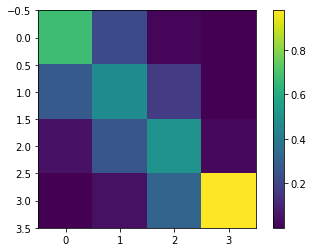

[[6.74136312e-01 2.21076488e-01 1.60157786e-02 1.89077032e-04]
 [2.75465189e-01 4.74862651e-01 1.69256078e-01 1.96932706e-03]
 [4.83050127e-02 2.59698884e-01 5.03151490e-01 2.13121486e-02]
 [2.09348598e-03 4.43619773e-02 3.11576654e-01 9.76529447e-01]]
epoch: 1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1051: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenev

Iter: 0/2, loss_train: 8.2855, loss_val: nan, lr: 0.001998
acc: 0.9371366279069767


,sample_id,epoch,batch_iter,labels,logits_0,logits_1,logits_2,logits_3
0,0.0,0.0,-1.0,3.0,1.523067e-09,3.329052e-03,4.983092e-01,0.498362
1,1.0,0.0,-1.0,3.0,7.251888e-08,8.742569e-17,5.330650e-05,0.999947
2,2.0,0.0,-1.0,3.0,8.116278e-10,2.838558e-16,6.720093e-10,1.000000
3,3.0,0.0,-1.0,3.0,4.436410e-13,1.185773e-18,5.949417e-05,0.999941
4,4.0,0.0,-1.0,3.0,9.381661e-15,3.077624e-15,1.137136e-16,1.000000
...,...,...,...,...,...,...,...,...
4369,1453.0,1.0,-1.0,3.0,4.384169e-09,7.093590e-10,1.509299e-06,0.999998
4370,1454.0,1.0,-1.0,3.0,4.058841e-09,2.304787e-07,5.435208e-10,1.000000
4371,1455.0,1.0,-1.0,3.0,1.444878e-10,7.539961e-09,1.071708e-08,1.000000
4372,1456.0,1.0,-1.0,3.0,1.281374e-08,1.879093e-10,1.920535e-09,1.000000


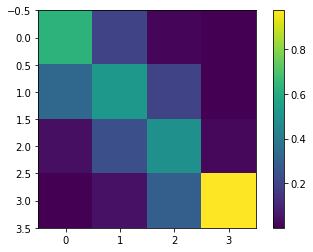

[[6.28330139e-01 1.98196944e-01 1.58522134e-02 3.21930264e-04]
 [3.30193006e-01 5.18867962e-01 1.98765233e-01 3.32892680e-03]
 [3.93204753e-02 2.36260553e-01 4.89555958e-01 2.27738303e-02]
 [2.15638026e-03 4.66745400e-02 2.95826596e-01 9.73575313e-01]]
epoch: 2


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1051: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenev

Iter: 0/2, loss_train: 8.2279, loss_val: nan, lr: 0.0019972
acc: 0.9325339147286822


,sample_id,epoch,batch_iter,labels,logits_0,logits_1,logits_2,logits_3
0,0.0,0.0,-1.0,3.0,1.523067e-09,3.329052e-03,4.983092e-01,0.498362
1,1.0,0.0,-1.0,3.0,7.251888e-08,8.742569e-17,5.330650e-05,0.999947
2,2.0,0.0,-1.0,3.0,8.116278e-10,2.838558e-16,6.720093e-10,1.000000
3,3.0,0.0,-1.0,3.0,4.436410e-13,1.185773e-18,5.949417e-05,0.999941
4,4.0,0.0,-1.0,3.0,9.381661e-15,3.077624e-15,1.137136e-16,1.000000
...,...,...,...,...,...,...,...,...
5827,1453.0,2.0,-1.0,3.0,1.683451e-06,3.600201e-07,1.512344e-07,0.999998
5828,1454.0,2.0,-1.0,3.0,7.726323e-07,2.398415e-09,6.156200e-09,0.999999
5829,1455.0,2.0,-1.0,3.0,2.431757e-09,2.767344e-09,5.495128e-09,1.000000
5830,1456.0,2.0,-1.0,3.0,2.158587e-07,8.754102e-10,1.820935e-09,1.000000


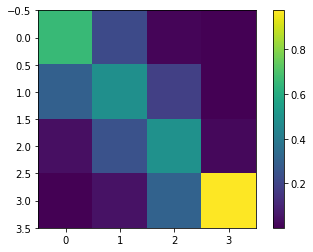

[[6.56447305e-01 2.19698283e-01 1.50889204e-02 3.47643012e-04]
 [2.99500345e-01 4.86384225e-01 1.86044181e-01 2.74170667e-03]
 [4.14602246e-02 2.44933051e-01 4.91744635e-01 2.14094551e-02]
 [2.59212553e-03 4.89844406e-02 3.07122264e-01 9.75501195e-01]]
epoch: 3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1051: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenev

Iter: 0/2, loss_train: 8.2097, loss_val: nan, lr: 0.0019964
acc: 0.9333817829457365


,sample_id,epoch,batch_iter,labels,logits_0,logits_1,logits_2,logits_3
0,0.0,0.0,-1.0,3.0,1.523067e-09,3.329052e-03,4.983092e-01,0.498362
1,1.0,0.0,-1.0,3.0,7.251888e-08,8.742569e-17,5.330650e-05,0.999947
2,2.0,0.0,-1.0,3.0,8.116278e-10,2.838558e-16,6.720093e-10,1.000000
3,3.0,0.0,-1.0,3.0,4.436410e-13,1.185773e-18,5.949417e-05,0.999941
4,4.0,0.0,-1.0,3.0,9.381661e-15,3.077624e-15,1.137136e-16,1.000000
...,...,...,...,...,...,...,...,...
7285,1453.0,3.0,-1.0,3.0,6.809399e-07,7.963905e-09,1.740610e-06,0.999998
7286,1454.0,3.0,-1.0,3.0,2.360829e-07,1.722400e-11,9.410316e-09,1.000000
7287,1455.0,3.0,-1.0,3.0,1.306401e-10,6.842392e-10,1.648245e-10,1.000000
7288,1456.0,3.0,-1.0,3.0,7.300341e-07,7.691756e-09,1.256263e-08,0.999999


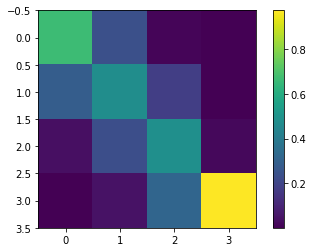

[[6.69516534e-01 2.39045836e-01 1.52696745e-02 3.21917499e-04]
 [2.87433391e-01 4.79383910e-01 1.80181836e-01 2.80191329e-03]
 [3.95226652e-02 2.34017655e-01 4.87051532e-01 2.17494892e-02]
 [3.52740936e-03 4.75525990e-02 3.17496958e-01 9.75126680e-01]]
epoch: 4


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1051: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenev

Iter: 0/2, loss_train: 8.1939, loss_val: nan, lr: 0.0019956
acc: 0.9318071705426356


,sample_id,epoch,batch_iter,labels,logits_0,logits_1,logits_2,logits_3
0,0.0,0.0,-1.0,3.0,1.523067e-09,3.329052e-03,4.983092e-01,0.498362
1,1.0,0.0,-1.0,3.0,7.251888e-08,8.742569e-17,5.330650e-05,0.999947
2,2.0,0.0,-1.0,3.0,8.116278e-10,2.838558e-16,6.720093e-10,1.000000
3,3.0,0.0,-1.0,3.0,4.436410e-13,1.185773e-18,5.949417e-05,0.999941
4,4.0,0.0,-1.0,3.0,9.381661e-15,3.077624e-15,1.137136e-16,1.000000
...,...,...,...,...,...,...,...,...
8743,1453.0,4.0,-1.0,3.0,2.285298e-07,2.322528e-08,1.900740e-06,0.999998
8744,1454.0,4.0,-1.0,3.0,7.506248e-08,3.390739e-10,6.825526e-09,1.000000
8745,1455.0,4.0,-1.0,3.0,1.229007e-08,2.837683e-10,2.129058e-12,1.000000
8746,1456.0,4.0,-1.0,3.0,2.687364e-07,3.555796e-08,9.230524e-08,1.000000


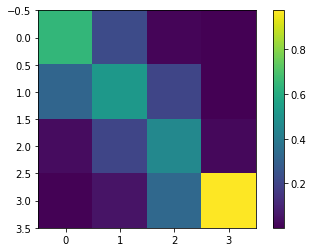

[[6.46007351e-01 2.24838518e-01 1.43417411e-02 2.75149386e-04]
 [3.16462991e-01 5.21717698e-01 2.02440667e-01 3.40530049e-03]
 [3.32582296e-02 2.03465395e-01 4.54458459e-01 2.09339579e-02]
 [4.27142812e-03 4.99783890e-02 3.28759132e-01 9.75385592e-01]]
epoch: 5


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1051: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenev

KeyboardInterrupt: ignored

In [51]:
%matplotlib inline

logreg = LogisticRegression(solver='liblinear')
logreg_predict_head = LogisticRegression(solver='liblinear')
dataset_train.classification_model = None

# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,
#                                                    gamma=1-0.001,
# #                                                    gamma=1,
#                                                   )
n_epochs=300000
for epoch in range(n_epochs):
    print(f'epoch: {epoch}')
    training_simCLR.epoch_step( dataloader_train, 
                                model, 
                                optimizer, 
                                criterion, 
                                scheduler=scheduler, 
                                temperature=0.5,
                                loss_rolling_train=losses_train, 
                                device=DEVICE, 
                                do_validation=False,
#                                 validation_Object=val_obj,
                                loss_rolling_val=losses_val,
                                verbose=2,
                                verbose_update_period=100,
                               )
    

    
    features_train = model(torch.as_tensor(util.expand_channels(X_labeled_train), device=DEVICE, dtype=torch.float32)).detach().cpu()
    # features_train = model(torch.as_tensor(X_labeled_train, device=DEVICE, dtype=torch.float32)[:,None,...]).detach().cpu()
    # features = model(torch.tensor(X_train[y_train != 3], device=DEVICE, dtype=torch.float32)[:,None,...]).detach().cpu()
    logreg.fit(features_train, y_labeled_train)
    acc.append(logreg.score(features_train, y_labeled_train))
    print(f'acc: {acc[-1]}')
    
    dataset_train.net_model = copy.deepcopy(model).to('cpu')
    dataset_train.classification_model = logreg
    

    sample_id_num = np.arange(X_labeled_val.shape[0])
    epoch_val = epoch
    batch_val = -1
    p_tmp = logreg.predict_proba(model(torch.as_tensor(util.expand_channels(X_labeled_val), device=DEVICE, dtype=torch.float32)).detach().cpu())
    logits = p_tmp
    # logits = np.log(1/(1/p_tmp - 1))

    col_vals = [sample_id_num, epoch_val, batch_val, y_labeled_val]
    setup = np.empty((len(sample_id_num), len(col_vals)))
    for icv, col_val in enumerate(col_vals):
      setup[:, icv] = col_val
    tmp_tracking_np = np.concatenate([setup, logits], axis=1)

    tmp_tracking_df = pd.DataFrame(tmp_tracking_np, index=sample_id_num, columns=tracking_df_cols + [f'logits_{i}' for i in range(logits.shape[1])])
    tracking_df = tracking_df.append(tmp_tracking_df, ignore_index=True)
    display(tracking_df)







    features_val = model(torch.as_tensor(util.expand_channels(X_labeled_val), device=DEVICE, dtype=torch.float32)).detach().cpu()


    # logreg_predict_head.fit(features_train, y_labeled_train)
    # y_hat = logreg_predict_head.predict_proba(features_val)

    y_hat = logreg.predict_proba(features_val)
    
    cm = rh_cm(y_hat, y_labeled_val)
    plt.figure()
    plt.imshow(cm)
    plt.colorbar()
    plt.show()
    print(cm)


    # tracking_df = tracking_df.append(pd.DataFrame([np.array([100, 0, 0, 0])], index=tracking_df_cols), ignore_index=True)
    
    # model predict
    # Update model in DS
    # get item calls model for each sample
    # output
    # X sample weights predictions
    
#     classHead.fit(X_train[:, None, :, :], y_train, solver='liblinear')
    
#     proba = classHead.predict_proba(X_train[:, None, :, :])
#     class_weights = proba.sum(axis=0)
#     total_num = class_weights.sum()
    
#     eps = 1e-4
    
#     class_weights[class_weights <= 3] = total_num
#     weightings = class_weights.sum()/class_weights
#     final_weights = weightings / weightings.sum()
#     final_weights = np.array([1/proba.shape[1] for _ in range(proba.shape[1])])
    
#     print(class_weights)

#     dataset_train.set_classweights(final_weights)
    
#     print('dataset_train.final_weights', dataset_train.class_weights)


In [15]:
# !cd "/content/drive/MyDrive/00 - ROI/GCaMP_ROI_classifier" && git add old_stuff
# !cd "/content/drive/MyDrive/00 - ROI/GCaMP_ROI_classifier" && git status
# !cd "/content/drive/MyDrive/00 - ROI/GCaMP_ROI_classifier" && git commit -m "Introducing ResNet and validating process"
!cd "/content/drive/MyDrive/00 - ROI/GCaMP_ROI_classifier" && git push

fatal: could not read Username for 'https://github.com': No such device or address


In [14]:
!git config --global user.email "$indianajonesjz@gmail.com"
!git config --global user.name "$joshuazimmer"

In [ ]:
plt.figure()
plt.plot(losses_train)

In [ ]:
plt.figure()
plt.plot(losses_train)

In [ ]:
%matplotlib inline
plt.figure()
plt.plot(losses_train)

In [ ]:
%matplotlib inline
plt.figure()
plt.plot(losses_train)

In [ ]:
plt.figure()
plt.plot(acc)

In [ ]:
features_train = model(torch.as_tensor(X_labeled_train, device=DEVICE, dtype=torch.float32)[:,None,...]).detach().cpu()
# features = model(torch.tensor(X_train[y_train != 3], device=DEVICE, dtype=torch.float32)[:,None,...]).detach().cpu()
logreg.fit(features_train, y_labeled_train)
y_hat = logreg.predict_proba(features_train)
cm = rh_cm(y_hat, y_labeled_train)

print(cm)

plt.figure()
plt.imshow(cm)
plt.colorbar()

In [ ]:
proba = classHead.predict_proba(dataset_train.X)

In [ ]:
# classHead.fit(X_train[:, None, :, :], y_train)



proba = classHead.predict_proba(X_train[:, None, :, :])
final_weights = np.array([1/proba.shape[1] for _ in range(proba.shape[1])])

dataset_train.set_classweights(final_weights)


In [ ]:
%load_ext autoreload
%autoreload 2

from basic_neural_processing_modules import decomposition

In [ ]:
logreg = LogisticRegression(solver='liblinear')
head = classHead.get_simCLR_head(X_train[:, None, ...])
# head = classHead.norm_head(head)
# head = head[:, [_ for _ in range(64) if _ not in [7, 15, 20, 21, 36, 54, 57, 60, 61, 62, 63, 64]]]
components , scores , decomposition.explained_variance_ratio_ , stds = decomposition.simple_pca(head, n_components=None)

# logreg.fit(scores[:, :], y_train)
# logreg.predict_proba(scores[:, :])
logreg.fit(head, y_train)
logreg.predict_proba(head)

In [ ]:
prd = logreg.predict_proba(head)
# prd = logreg.predict_proba(scores[:, :2])
plt.figure()
# plt.plot(logreg.predict_proba(scores[:, :2]))
plt.plot(logreg.predict_proba(head))

In [ ]:
# cm = confusion_matrix(y_train, np.argmax(logreg.predict_proba(scores[:, :2]), axis=1))
cm = confusion_matrix(y_train, np.argmax(logreg.predict_proba(head), axis=1))
cm = np.round(cm/cm.sum(axis=0), 2)
cm

In [ ]:
logreg.predict_proba(classHead.get_simCLR_head(X_val[:, None, :, :]))

In [ ]:
classHead.fit(X_train[:, None, :, :], y_train)

In [ ]:
classHead.predict_proba(X_train[:, None, :, :])

In [ ]:
idx_sample = 5
classHead.predict_proba(X_train[idx_sample:idx_sample+1, None, ...])

In [ ]:
sample_weight = util.loss_uncertainty(torch.as_tensor(proba), temperature=1, class_value=dataset_train.class_weights)

## Check embeddings

In [ ]:
torch.cuda.empty_cache()

In [ ]:
features = model(torch.tensor(images_labeled, device=DEVICE, dtype=torch.float32)[:,None,...]).detach()
# features = model(torch.tensor(images_labeled[labels != 3], device=DEVICE, dtype=torch.float32)[:,None,...]).detach()
# features = model(torch.tensor(X_val, device=DEVICE, dtype=torch.float32)[:,None,...]).detach()
# features = model(torch.tensor(X_train, device=DEVICE, dtype=torch.float32)[:,None,...]).detach()

In [ ]:
_, features_embedded, _, _ = decomposition.torch_pca(features, device=DEVICE, return_cpu=True)

In [ ]:
from sklearn import manifold

tsne = manifold.TSNE(n_components=2, 
                     perplexity=80.0, 
                     early_exaggeration=12.0, 
                     learning_rate=200, 
                     n_iter=1000, 
                     n_iter_without_progress=300, 
                     min_grad_norm=1e-07, 
                     metric='euclidean', 
                     init='pca', 
                     verbose=0, 
                     random_state=None, 
                     method='barnes_hut', 
                     angle=0.5, 
                     n_jobs=-1, 
#                      square_distances='legacy'
                    )
features_embedded = tsne.fit_transform(features.cpu())

In [ ]:
import matplotlib as mpl

# mpl.rcParams['image.cmap'] = 'Set1'
%matplotlib notebook
plt.figure()
plt.scatter(features_embedded[:,0], features_embedded[:,1], c=labels)
# plt.scatter(features_embedded[:,0], features_embedded[:,1], c=labels[labels!=3])
# plt.scatter(features_embedded[:,0], features_embedded[:,1], c=y_val)
# plt.scatter(features_embedded[:,4], features_embedded[:,5], c=y_train)
# plt.scatter(features_embedded[:,11], features[:,43].cpu(), c=y_train)
mpl.rcParams['image.cmap'] = 'viridis'


In [ ]:
plt.figure()
plt.imshow(features.cpu().detach(), aspect='auto', interpolation='none')

## Check filters

In [ ]:
list(model.state_dict().keys())

In [ ]:
layer_1 = model.state_dict()['cnn_layers.0.weight'].cpu()
layer_2 = model.state_dict()['cnn_layers.2.weight'].cpu()
layer_3 = model.state_dict()['cnn_layers.5.weight'].cpu()
layer_4 = model.state_dict()['cnn_layers.8.weight'].cpu()

plt.figure()
for ii in range(layer_1.shape[1]):
    for jj in range(layer_1.shape[0]):
        plt.subplot2grid((layer_1.shape[1],layer_1.shape[0]),(ii,jj))
        fig = plt.imshow(layer_1[jj,ii,:,:] , clim=(-0.2,0.2))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

plt.figure()
for ii in range(layer_2.shape[1]):
    for jj in range(layer_2.shape[0]):
        plt.subplot2grid((layer_2.shape[1],layer_2.shape[0]),(ii,jj))
        fig = plt.imshow(layer_2[jj,ii,:,:], clim=(-.05,.05))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

plt.figure()
for ii in range(16):
    for jj in range(16):
        plt.subplot2grid((16,16),(ii,jj))
        fig = plt.imshow(layer_3[jj, ii,:,:])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        
plt.figure()
for ii in range(16):
    for jj in range(16):
        plt.subplot2grid((16,16),(ii,jj))
        fig = plt.imshow(layer_4[jj, ii,:,:])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

In [ ]:
# torch.save(model.state_dict(), '/media/rich/bigSSD/Net_trainedOnAug_20211025_trainingSet_mouse628_20200903and20200815_simCLR.pth')

In [ ]:
# model = Net()
# model.load_state_dict(torch.load('test_save.pth'))
# model.eval()